In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 37.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.optimize import AdamOptimizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/ClaMP_Integrated-5184.csv', sep=',')
df.drop(['packer_type'],axis=1,inplace=True)
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)
df = df.astype(float)

train,test = train_test_split(df, test_size=0.30, random_state=2)

train_set = train.sample(160)
test_set = test.sample(40)

# Separation of labels
x_train = train_set.drop('class', axis=1)
y_train = train_set[['class']]

x_test = test_set.drop('class', axis=1)
y_test = test_set[['class']]

# Reduce dimensions using PCA to fit the dimensions with the qubits
n_dim = 2
pca = PCA(n_components=n_dim)
pca.fit(x_train)

x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

# Normalize
std_scale = StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)

std_scale = StandardScaler().fit(x_test)
x_test = std_scale.transform(x_test)

# Angle Encoding
num_qubits = n_dim
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev)
def circuit(weights, x, idx, apply_sign=False):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = x[idx], wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = weights, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))


# Initialize the weights and bias
np.random.seed(0)
num_layers = 2
initial_weights = np.random.randn(num_layers, num_qubits, 3)
bias = 0.0

# Set the number of steps and the learning rate
num_steps = 10
learning_rate = 0.1

# Initialize the optimizer
opt = AdamOptimizer(learning_rate)

def cost_fn(weights, bias, x, y):
    total_cost = 0
    for i in range(x.shape[0]):
        prediction = circuit(weights, x, i, apply_sign=True) + bias
        total_cost += (prediction - y[i]) ** 2
    return total_cost / x.shape[0]

def fgsm(weights, bias, x, y, epsilon):
    gradient_fn = qml.grad(cost_fn, argnum=[0, 1])
    gradient_weights, gradient_bias = gradient_fn(weights, bias, x, y)
    perturbation_weights = epsilon * np.sign(gradient_weights)
    perturbation_bias = epsilon * np.sign(gradient_bias)
    weights_perturbed = weights + perturbation_weights
    bias_perturbed = bias + perturbation_bias
    return weights_perturbed, bias_perturbed




In [ ]:
params = np.concatenate([initial_weights.flatten(), np.array([bias])])

epsilon = 0.01  # FGSM perturbation size 

In [ ]:
# Assuming your data has already been preprocessed (scaling, etc.)

# Import PCA from sklearn
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=2)

# Fit PCA on your training data
pca.fit(x_train)

# Transform your training data
x_train_pca = pca.transform(x_train)


In [ ]:
weights = initial_weights
bias = np.array([bias])

for i in range(num_steps):
    # Generate perturbed parameters
    weights_perturbed, bias_perturbed = fgsm(weights, bias, x_train_pca, y_train.values, epsilon)

    # Optimize weights and bias on perturbed parameters
    weights, bias = opt.step(lambda v, b: cost_fn(v, b, x_train_pca, y_train.values), weights_perturbed, bias_perturbed)


/usr/local/lib/python3.10/dist-packages/pennylane/_grad.py:109: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


In [ ]:
x_test_pca = pca.transform(x_test)

In [ ]:
y_test_pred = [circuit(params[:-1].reshape((num_layers, num_qubits, 3)), x_test_pca, i, apply_sign=True) + params[-1] for i in range(x_test_pca.shape[0])]


In [ ]:
y_test_pred_labels = np.array([0 if pred < 0 else 1 for pred in y_test_pred])


In [ ]:
from sklearn import metrics

# Convert your test predictions to a numpy array if they are not in that format already
y_test_pred_labels = np.array(y_test_pred_labels)

# Print the classification report
print(metrics.classification_report(y_test.values, y_test_pred_labels))

# Print precision, recall, and f1 score
print("Precision:", metrics.precision_score(y_test.values, y_test_pred_labels))
print("Recall:", metrics.recall_score(y_test.values, y_test_pred_labels))
print("F1 Score:", metrics.f1_score(y_test.values, y_test_pred_labels))

# Print the balanced accuracy score
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test.values, y_test_pred_labels))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.46      0.95      0.62        19

    accuracy                           0.45        40
   macro avg       0.23      0.47      0.31        40
weighted avg       0.22      0.45      0.29        40

Precision: 0.46153846153846156
Recall: 0.9473684210526315
F1 Score: 0.6206896551724138
Balanced Accuracy: 0.47368421052631576


In [ ]:
print("Unique values in y_test:", np.unique(y_test.values))
print("Unique values in predictions:", np.unique(y_test_pred_labels))


Unique values in y_test: [0. 1.]
Unique values in predictions: [0 1]


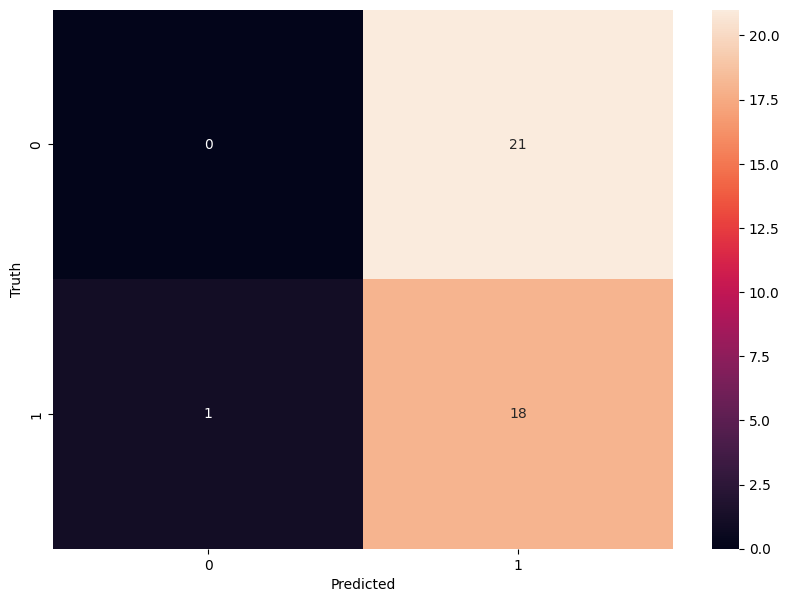

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test.values, y_test_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


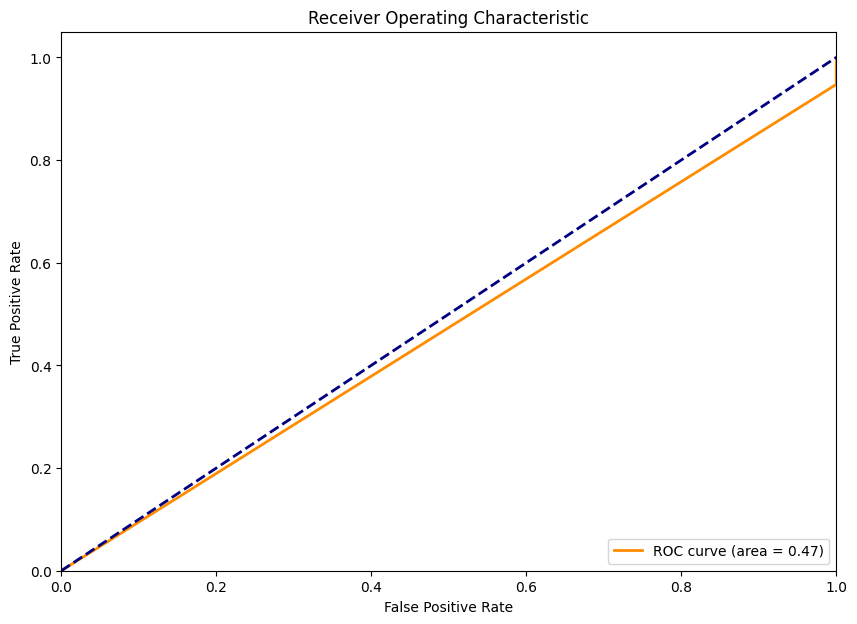

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test.values, y_test_pred_labels)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
